In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist/", one_hot=True)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [2]:
num_train=mnist.train.num_examples
num_val=mnist.validation.images.shape
num_test=mnist.test.images.shape

In [3]:
batch_size=64
img_size=28
RNN_unit=img_size*img_size
N_watch=10

In [4]:
tf.reset_default_graph()
X=tf.placeholder(dtype=tf.float32,shape=[None,img_size*img_size])
y=tf.placeholder(dtype=tf.int64,shape=[None,10])

predict_net=tf.layers.Dense(units=10)

def get_next_input(output, i):
    attention_weight=tf.nn.softmax(output)
    weighted_graph=X*attention_weight
    return weighted_graph

lstm_cell = tf.nn.rnn_cell.LSTMCell(RNN_unit, state_is_tuple=True)
init_state = lstm_cell.zero_state(batch_size, tf.float32)

inputs=[X]
inputs.extend([0]*N_watch)
outputs,_ = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, init_state, lstm_cell, loop_function=get_next_input)

output=outputs[-1]
score=predict_net(output)

predictions = tf.argmax(score, 1)
correct_predictions = tf.equal(predictions, tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"))

loss=tf.losses.softmax_cross_entropy(onehot_labels=y,logits=score)
optimizier=tf.train.AdamOptimizer(learning_rate=1e-5)
train_step = optimizier.minimize(loss)

In [5]:
max_epoch=50
print_every=200

def train():
    num_iteration=num_train//batch_size
    for it in range(num_iteration):
        images,labels=mnist.train.next_batch(batch_size)
        loss_num,_ = sess.run([loss,train_step],feed_dict={X:images,y:labels})
        if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
            print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'iteration %d/%d:' % (it+1,num_iteration),'current training loss = %f' % (loss_num))
            
def eval(dataset,num_iteration):
    total_loss=0
    total_accuracy=0
    for it in range(num_iteration):
        images,labels=dataset.next_batch(batch_size)
        loss_num,accuracy_num = sess.run([loss,accuracy],feed_dict={X:images,y:labels})
        total_loss+=loss_num
        total_accuracy+=accuracy_num
    total_loss/=num_iteration
    total_accuracy/=num_iteration
    return total_loss,total_accuracy
    
acc_train_his=[]
acc_val_his=[]
acc_test_his=[]

saver = tf.train.Saver()
    
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(max_epoch):
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'start epoch %d/%d:' % (epoch+1,max_epoch))
        train()
        loss_train,acc_train=eval(mnist.train,2000)
        loss_val,acc_val=eval(mnist.validation,500)
        loss_test,acc_test=eval(mnist.test,1000)
        acc_train_his.append(acc_train)
        acc_val_his.append(acc_val)
        acc_test_his.append(acc_test)
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'end epoch %d/%d:' % (epoch+1,max_epoch),
             'acc_train=%.3f%% acc_val=%.3f%% acc_test=%.3f%%' % (acc_train*100.0,acc_val*100.0,acc_test*100.0))
    save_path = saver.save(sess, "model/SRAM/SRAM.ckpt")
    print("Model saved in path: %s" % save_path)

2018-04-16 14:38:17 start epoch 1/50:
2018-04-16 14:38:19 iteration 1/859: current training loss = 2.304162
2018-04-16 14:38:20 iteration 200/859: current training loss = 2.060483
2018-04-16 14:38:22 iteration 400/859: current training loss = 0.852045
2018-04-16 14:38:24 iteration 600/859: current training loss = 0.758529
2018-04-16 14:38:26 iteration 800/859: current training loss = 0.398900
2018-04-16 14:38:27 iteration 859/859: current training loss = 0.761768
2018-04-16 14:38:42 end epoch 1/50: acc_train=83.753% acc_val=84.531% acc_test=83.948%
2018-04-16 14:38:42 start epoch 2/50:
2018-04-16 14:38:42 iteration 1/859: current training loss = 0.553279
2018-04-16 14:38:44 iteration 200/859: current training loss = 0.649777
2018-04-16 14:38:46 iteration 400/859: current training loss = 0.252843
2018-04-16 14:38:49 iteration 600/859: current training loss = 0.257547
2018-04-16 14:38:51 iteration 800/859: current training loss = 0.457916
2018-04-16 14:38:52 iteration 859/859: current tr

2018-04-16 14:43:58 end epoch 15/50: acc_train=96.855% acc_val=96.116% acc_test=96.116%
2018-04-16 14:43:58 start epoch 16/50:
2018-04-16 14:43:58 iteration 1/859: current training loss = 0.140693
2018-04-16 14:44:01 iteration 200/859: current training loss = 0.067489
2018-04-16 14:44:03 iteration 400/859: current training loss = 0.097634
2018-04-16 14:44:04 iteration 600/859: current training loss = 0.092372
2018-04-16 14:44:06 iteration 800/859: current training loss = 0.067582
2018-04-16 14:44:07 iteration 859/859: current training loss = 0.117369
2018-04-16 14:44:21 end epoch 16/50: acc_train=96.993% acc_val=96.272% acc_test=96.027%
2018-04-16 14:44:21 start epoch 17/50:
2018-04-16 14:44:21 iteration 1/859: current training loss = 0.142518
2018-04-16 14:44:23 iteration 200/859: current training loss = 0.121414
2018-04-16 14:44:24 iteration 400/859: current training loss = 0.025635
2018-04-16 14:44:26 iteration 600/859: current training loss = 0.193744
2018-04-16 14:44:29 iteration 

2018-04-16 14:49:26 iteration 800/859: current training loss = 0.024762
2018-04-16 14:49:26 iteration 859/859: current training loss = 0.012821
2018-04-16 14:49:41 end epoch 30/50: acc_train=98.455% acc_val=97.159% acc_test=97.109%
2018-04-16 14:49:41 start epoch 31/50:
2018-04-16 14:49:41 iteration 1/859: current training loss = 0.029839
2018-04-16 14:49:44 iteration 200/859: current training loss = 0.013444
2018-04-16 14:49:46 iteration 400/859: current training loss = 0.133244
2018-04-16 14:49:48 iteration 600/859: current training loss = 0.014293
2018-04-16 14:49:50 iteration 800/859: current training loss = 0.031515
2018-04-16 14:49:51 iteration 859/859: current training loss = 0.053485
2018-04-16 14:50:05 end epoch 31/50: acc_train=98.455% acc_val=97.278% acc_test=97.033%
2018-04-16 14:50:05 start epoch 32/50:
2018-04-16 14:50:05 iteration 1/859: current training loss = 0.075821
2018-04-16 14:50:07 iteration 200/859: current training loss = 0.014118
2018-04-16 14:50:09 iteration 

2018-04-16 14:55:06 iteration 400/859: current training loss = 0.023062
2018-04-16 14:55:08 iteration 600/859: current training loss = 0.040162
2018-04-16 14:55:10 iteration 800/859: current training loss = 0.020081
2018-04-16 14:55:11 iteration 859/859: current training loss = 0.043714
2018-04-16 14:55:24 end epoch 45/50: acc_train=99.283% acc_val=97.297% acc_test=97.428%
2018-04-16 14:55:24 start epoch 46/50:
2018-04-16 14:55:24 iteration 1/859: current training loss = 0.059119
2018-04-16 14:55:26 iteration 200/859: current training loss = 0.030551
2018-04-16 14:55:29 iteration 400/859: current training loss = 0.020510
2018-04-16 14:55:31 iteration 600/859: current training loss = 0.018962
2018-04-16 14:55:33 iteration 800/859: current training loss = 0.002500
2018-04-16 14:55:34 iteration 859/859: current training loss = 0.010331
2018-04-16 14:55:47 end epoch 46/50: acc_train=99.097% acc_val=97.356% acc_test=96.978%
2018-04-16 14:55:47 start epoch 47/50:
2018-04-16 14:55:47 iteratio

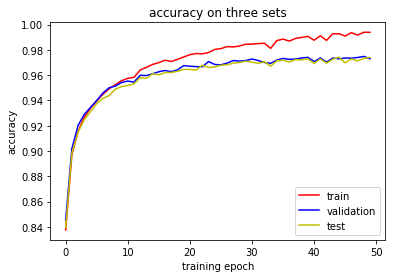

In [6]:
plt.figure(2)
ptr,=plt.plot(range(max_epoch),acc_train_his,'r-')
pva,=plt.plot(range(max_epoch),acc_val_his,'b-')
pte,=plt.plot(range(max_epoch),acc_test_his,'y-')
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.title('accuracy on three sets')
plt.legend((ptr,pva,pte),('train','validation','test'))
plt.show()